>[Load Colab](#scrollTo=0oVgMzR_ywr_)

>[initiate](#scrollTo=2y1omcz8ywsF)

>[Gleason Score](#scrollTo=diKStuuskvkS)

>[Augment](#scrollTo=aqf2izgHRetB)

>[Transform](#scrollTo=L3A1UwZUywsS)

>[Train](#scrollTo=QA0eNCpVywsW)

>[ResNet](#scrollTo=AOE9Lac4k6cy)

>[Trash](#scrollTo=txse4NidVs-S)

>>[Check](#scrollTo=QAA2fmxbywsV)

>>[3 attempt](#scrollTo=oEDLevmu6TRU)



In [ ]:
!git clone https://github.com/rcuocolo/PROSTATEx_masks

Cloning into 'PROSTATEx_masks'...
remote: Enumerating objects: 5026, done.
remote: Counting objects: 100% (376/376), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 5026 (delta 353), reused 195 (delta 179), pack-reused 4650
Receiving objects: 100% (5026/5026), 902.72 MiB | 14.32 MiB/s, done.
Resolving deltas: 100% (3701/3701), done.
Updating files: 100% (2565/2565), done.


# Load Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#for colab
%cd "/content/drive/MyDrive/Prostate_Lesion/"

/content/drive/.shortcut-targets-by-id/1wCK5vBkYx3cQUsc06EFZG4zaqE0idTPk/Prostate_Lesion


In [ ]:
%pip install -r requirement.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.3/91.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 87.7 MB/s eta 0:00:00


# initiate

In [ ]:
import pandas as pd
import nibabel as nib
import os
from glob import glob
import shutil
from tqdm import tqdm
import dicom2nifti
import numpy as np
import nibabel as nib
import pandas as pd


import json
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import os

from monai.utils import first

In [ ]:
HOME_DIR =       "./"
DATA_DIR =       "./PROSTATEx_masks/Files/lesions/"
OUT_DIR =        "./results/lesion/"
SLICED_OUT_DIR = "./data/sliced/"
AUG_OUT_DIR = "./data/augmented/"

In [ ]:
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss, DiceCELoss
from tqdm import tqdm

from utils.train import train

# Preprocessing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Prostate_Lesion/PROSTATEx_masks/Files/lesions/Image_list.csv')

In [ ]:
import os
if not os.path.exists(SLICED_OUT_DIR + "images/"):
    os.makedirs(SLICED_OUT_DIR + "images/")
if not os.path.exists(SLICED_OUT_DIR + "prostates/"):
    os.makedirs(SLICED_OUT_DIR + "prostates/")
if not os.path.exists(SLICED_OUT_DIR + "pz_masks/"):
    os.makedirs(SLICED_OUT_DIR + "pz_masks/")
if not os.path.exists(SLICED_OUT_DIR + "tz_masks/"):
    os.makedirs(SLICED_OUT_DIR + "tz_masks/")
if not os.path.exists(SLICED_OUT_DIR + "labels/"):
    os.makedirs(SLICED_OUT_DIR + "labels/")

In [ ]:
data = []
for index, row in df.iterrows():
    value = row['T2'].split("-")
    numb= value[1].split("_")[0]
    if int(numb) == 128:
        t2 = DATA_DIR+'Images/T2/'+row['T2']+'.nii'
    else:
        t2 = DATA_DIR+'Images/T2/'+row['T2']+'.nii.gz'
    if int(numb) == 25:
        adc = DATA_DIR+'Images/ADC/'+row['ADC']+'a.nii.gz'
    elif int(numb) == 113:
        value = row['ADC'][:-2]+'9'
        adc = DATA_DIR+'Images/ADC/'+value+'.nii.gz'
    elif int(numb) == 203:
        adc = DATA_DIR+'Images/ADC/'+'ProstateX-0203_diffusie-3ProstateX-0203_diffusie-3Scan-4bval_fs_7.niiScan-4bval_fs_7.nii.gz'
    else:
        adc = DATA_DIR+'Images/ADC/'+row['ADC']+'.nii.gz'
   
    data.append({ 'T2': t2, 'ADC': adc , 'name': value[0] + '_' +str(numb)})

In [ ]:
import nibabel as nib
import json
import numpy as np

def load_nifti(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    image = nib.load(image_nifty_file)
    label = nib.load(label_nifty_file)
    
    return image, label

def save_to_json(data, path):
  with open(path, 'w') as fp:
    json.dump(data, fp)


def remove_slices(img,start, end):
  imgvol = np.array( img.dataobj )
  imgvol = imgvol[ :, :, start:end ]
  newimg = nib.Nifti1Image ( imgvol, img.affine )
  return newimg



In [ ]:
df = pd.read_csv(DATA_DIR +'image_list.csv')

In [ ]:
import os
import nibabel as nib

# specify the directory path
image_path = './PROSTATEx_masks/Files/prostate/Images/'
prostate_path = './PROSTATEx_masks/Files/prostate/mask_prostate/'
pz_path = './PROSTATEx_masks/Files/prostate/mask_pz/'
tz_path = './PROSTATEx_masks/Files/prostate/mask_tz/'
lesion_path = './PROSTATEx_masks/Files/lesions/Masks/T2/'
#t2_path = './PROSTATEx_masks/Files/lesions/Images/T2/'
#adc_path = './PROSTATEx_masks/Files/lesions/Masks/ADC/'

# get all the file names in the directory
t2_images = os.listdir(image_path)
prostates = os.listdir(prostate_path)
pz_images = os.listdir(pz_path)
tz_images = os.listdir(tz_path)
t2_lesions = os.listdir(lesion_path)
#t2_2 = os.listdir(t2_path)
#adc_images = os.listdir(adc_path)

data = []
for i in range(len(df['T2'])):
    t2 = nib.load(image_path + t2_images[i])
    prostate = nib.load(prostate_path + prostates[i])
    pz = nib.load(pz_path + pz_images[i])
    tz = nib.load(tz_path + tz_images[i])
    lesion = nib.load(lesion_path + t2_lesions[i])
    name = t2_images[i].split('_')[0]

    
    if t2.shape[2] == lesion.shape[2]:
        path = {
            'T2': image_path + t2_images[i],
            'prostate': prostate_path + prostates[i],
            'PZ' : pz_path + pz_images[i],
            'TZ': tz_path + tz_images[i],
            'label': lesion_path + t2_lesions[i],
            'Name':name
        }
        data.append(path)





In [ ]:
import nibabel as nib
import json
import numpy as np

def load_nifti(image_path_1,image_path_2,image_path_3,image_path_4, label_path):
    # load the image and label file, get the image content and return a numpy array for each
    image1 = nib.load(image_path_1)
    image2 = nib.load(image_path_2)
    image3 = nib.load(image_path_3)
    image4 = nib.load(image_path_4)
    label = nib.load(label_path)
    
    return image1,image2,image3,image4, label

def save_to_json(data, path):
  with open(path, 'w') as fp:
    json.dump(data, fp)


def remove_slice(img,  slice_size):
    total_slize_size = img.shape[2]
    extra_slices = total_slize_size - slice_size
    end  = total_slize_size - (extra_slices // 2 )
    start = end - slice_size 
    imgvol = np.array( img.dataobj )
    imgvol = imgvol[ :, :, start:end ]
    newimg = nib.Nifti1Image ( imgvol, img.affine )
    return newimg

def create_same_slice_nifti(data, slice_size ,dir):
  paths = []
  total = len(data)
  count = 1
  for entry in data:
    image, prostate, pz , tz, label = load_nifti(entry["T2"], entry["prostate"], entry["PZ"], entry["TZ"], entry["label"])

    total_slize_size = min( image.shape[2], prostate.shape[2], pz.shape[2] , tz.shape[2], label.shape[2])
    if(total_slize_size < slice_size): 
      print("ERROR: slice upper limit exceeds")
      continue
    

    new_image = remove_slice(image,slice_size)
    new_prostate = remove_slice(prostate,slice_size)
    new_pz = remove_slice(pz,slice_size)
    new_tz = remove_slice(tz,slice_size)
    new_lbl = remove_slice(label,slice_size)

    image_path = dir + 'images/'+ entry['Name']+'.nii.gz'
    label_path = dir + 'labels/' + entry['Name']+'.nii.gz'
    prostate_path = dir + 'prostates/' + entry['Name']+'.nii.gz'
    pz_path = dir + 'pz_masks/' + entry['Name']+'.nii.gz'
    tz_path = dir + 'tz_masks/' + entry['Name']+'.nii.gz'
    
    paths.append({
      "image":image_path, 
      'prostate':prostate_path,
      'PZ': pz_path,
      'TZ' : tz_path,
      "label":label_path, 
    })
    new_image.to_filename(image_path)
    new_prostate.to_filename(prostate_path)
    new_pz.to_filename(pz_path)
    new_tz.to_filename(tz_path)
    new_lbl.to_filename(label_path)
    
    print(f"{count}/{total}")
    count += 1

  save_to_json({"path": paths}, dir + 'config.json')





In [ ]:
slice_size = 16
create_same_slice_nifti(data, slice_size ,SLICED_OUT_DIR)

# Gleason Score

In [ ]:
def get_data_path(path):
  f = open( path + 'config.json')
  jdata = json.load(f)
  f.close()
  return jdata["path"]

In [ ]:
data = get_data_path(SLICED_OUT_DIR)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Prostate_Lesion/PROSTATEx_masks/Files/lesions/PROSTATEx_Classes.csv')


In [ ]:
df['Gleason Grade Group'] = df['Gleason Grade Group'].replace('No biopsy information', '0')

In [ ]:
df['Gleason Grade Group'].unique()

array(['3', '1', '2', '0', '4', '5'], dtype=object)

In [ ]:
df['Gleason Grade Group'].value_counts()

0    187
2     41
1     36
3     20
4      8
5      7
Name: Gleason Grade Group, dtype: int64

In [ ]:
import os

# Define the file path
file_path = './data/sliced/images/ProstateX-0170-Finding2.nii.gz'

def getFileName(file_path):

  # Get the base filename without the extension
  file_name = os.path.basename(file_path)
  file_name = os.path.splitext(file_name)[0]

  # Remove the '.nii' extension
  file_name = file_name.replace('.nii', '')

  return file_name

# Display the filename
print('File name:', getFileName(file_path))


File name: ProstateX-0170-Finding2


In [ ]:
df.nunique()

ID                        299
Clinically Significant      2
Gleason Grade Group         6
dtype: int64

In [ ]:
def save_to_json(data, path):
  with open(path, 'w') as fp:
    json.dump(data, fp)

In [ ]:
updated_data = []
df['ID'] = df['ID'].str.replace('_','-')


for row in data:
  name = getFileName(row['image'])
 
  gleason = df[ df['ID'] == name]
  row['name'] = name
  row['Clinically Significant'] = str(gleason['Clinically Significant'].values[0])
  row['Gleason Grade Group'] = gleason['Gleason Grade Group'].values[0]
  updated_data.append(row)
 

save_to_json({"path": updated_data}, SLICED_OUT_DIR + 'combined_config.json')   

# Augment

In [ ]:
def get_data_path(path):
  f = open( path + 'combined_config.json')
  jdata = json.load(f)
  f.close()
  return jdata["path"]

In [ ]:
combine_data = data = get_data_path(SLICED_OUT_DIR)

In [ ]:
indexes = [[],[],[],[],[],[]]

for i, data in enumerate(combine_data):  
  indexes[int(data['Gleason Grade Group'])].append(data)


In [ ]:
import nibabel as nib
import random
import elasticdeform 
import numpy as np
import nibabel as nib
import time

from scipy.ndimage import affine_transform, rotate, zoom
from skimage.exposure import adjust_gamma, rescale_intensity
from skimage.util import random_noise
from scipy.ndimage import map_coordinates
from scipy.ndimage import gaussian_filter


def rotated(voxels, mask_1, mask_2, mask_3, lbl, theta = None):
    # Rotate volume by a minor angle (+/- 10 degrees: determined by investigation of dataset variability)
    if theta is None:
        theta = random.randint(-10, 10)
    vox_new = rotate(voxels, theta, reshape = False)
    mask_1_new = rotate(mask_1, theta, reshape = False)
    mask_2_new = rotate(mask_2, theta, reshape = False)
    mask_3_new = rotate(mask_3, theta, reshape = False)
    lbl_new =  rotate(lbl, theta, reshape = False)

    return vox_new, mask_1_new, mask_2_new, mask_3_new, lbl

def scale_and_crop(voxels, mask_1, mask_2, mask_3, lbl):
    # Scale the volume by a minor size and crop around centre (can also modify for random crop)
    o_s = voxels.shape
    r_s = [0]*len(o_s)
    scale_factor = random.uniform(1, 1.2)
    vox_zoom = zoom(voxels, scale_factor, order=1)
    mask_1_zoom = zoom(mask_1, scale_factor, order=0)
    mask_2_zoom = zoom(mask_2, scale_factor, order=0)
    mask_3_zoom = zoom(mask_3, scale_factor, order=0)
    lbl_zoom = zoom(lbl, scale_factor, order=0)
    new_shape = vox_zoom.shape
    # Start with offset
    for i in range(len(o_s)):
        if new_shape[i] == 1: 
            r_s[i] = 0
            continue
        r_c = int(((new_shape[i] - o_s[i]) - 1)/2)
        r_s[i] = r_c
    r_e = [r_s[i] + o_s[i] for i in list(range(len(o_s)))]
    vox_zoom = vox_zoom[r_s[0]:r_e[0], r_s[1]:r_e[1], r_s[2]:r_e[2]]
    mask_1_zoom = mask_1_zoom[r_s[0]:r_e[0], r_s[1]:r_e[1], r_s[2]:r_e[2]]
    mask_2_zoom = mask_2_zoom[r_s[0]:r_e[0], r_s[1]:r_e[1], r_s[2]:r_e[2]]
    mask_3_zoom = mask_3_zoom[r_s[0]:r_e[0], r_s[1]:r_e[1], r_s[2]:r_e[2]]
    lbl_zoom = lbl_zoom[r_s[0]:r_e[0], r_s[1]:r_e[1], r_s[2]:r_e[2]]
    return vox_zoom, mask_1_zoom, mask_2_zoom, mask_3_zoom, lbl_zoom

def grayscale_variation(voxels,  mask_1, mask_2, mask_3, lbl):
    # Introduce a random global increment in gray-level value of volume. 
    im_min = np.min(voxels)
    im_max = np.max(voxels)
    mean = np.random.normal(0, 0.1)
    smp = np.random.normal(mean, 0.01, size = np.shape(voxels))
    voxels = voxels + im_max*smp
    voxels[voxels <= im_min] = im_min # Clamp to min value
    voxels[voxels > im_max] = im_max  # Clamp to max value
    return voxels, mask_1, mask_2, mask_3, lbl


def elastic_deformation(voxels, mask_1, mask_2, mask_3, lbl, alpha=None, sigma=None, mode="constant", cval=0, is_random=False): 
    # Apply elastic deformation/distortion to the wolume
    # Adapted from: https://tensorlayer.readthedocs.io/en/stable/_modules/tensorlayer/prepro.html#elastic_transform
    if alpha == None:
        alpha=voxels.shape[1]*3.
    if sigma == None:
        sigma=voxels.shape[1]*0.07
    if is_random is False:
        random_state = np.random.RandomState(None)
    else:
        random_state = np.random.RandomState(int(time.time()))
        
    if len(voxels.shape) == 3:
        voxels = np.reshape(voxels, (voxels.shape[0], voxels.shape[1], voxels.shape[2], 1) )
        mask_1 = np.reshape(mask_1, (mask_1.shape[0], mask_1.shape[1],mask_1.shape[2], 1) )
        mask_2 = np.reshape(mask_2, (mask_2.shape[0], mask_2.shape[1],mask_2.shape[2], 1) )
        mask_3 = np.reshape(mask_3, (mask_3.shape[0], mask_3.shape[1],mask_3.shape[2], 1) )
        lbl = np.reshape( lbl, (lbl.shape[0], lbl.shape[1], lbl.shape[2], 1 ) )
        
    shape = (voxels.shape[0], voxels.shape[1])
    label_shape = (lbl.shape[0], lbl.shape[1])
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode=mode, cval=cval) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode=mode, cval=cval) * alpha
    x_, y_ = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x_ + dx, (-1, 1)), np.reshape(y_ + dy, (-1, 1))
    
    new_voxels = np.zeros(voxels.shape)
    new_mask_1 = np.zeros(mask_1.shape)
    new_mask_2 = np.zeros(mask_2.shape)
    new_mask_3 = np.zeros(mask_3.shape)
    new_lbl = np.zeros( lbl.shape)
    for i in range(voxels.shape[2]): # apply the same distortion to each slice within the volume
        new_voxels[:,:,i,0] = map_coordinates(voxels[:,:,i,0], indices, order=1).reshape(shape)
        new_mask_1[:,:,i,0] = map_coordinates(mask_1[:,:,i,0], indices, order=1).reshape(shape)
        new_mask_2[:,:,i,0] = map_coordinates(mask_2[:,:,i,0], indices, order=1).reshape(shape)
        new_mask_3[:,:,i,0] = map_coordinates(mask_3[:,:,i,0], indices, order=1).reshape(shape)
        new_lbl[:,:,i,0] = map_coordinates(lbl[:,:,i,0], indices, order=1).reshape( label_shape)
        
    return new_voxels.squeeze(), new_mask_1.squeeze(), new_mask_2.squeeze(), new_mask_3.squeeze(), new_lbl.squeeze()


    
def translate(image, mask_1, mask_2, mask_3, lbl):

    translate = (random.uniform(-10, 10), random.uniform(-10, 10))
    matrix = np.array([[1, 0, 0, translate[0]], [0, 1, 0, translate[1]], [0, 0, 1, 0], [0, 0, 0, 1]])

    # Translate
    img = affine_transform(image, matrix, order=1)
    mask_1_new = affine_transform(mask_1, matrix, order=0)
    mask_2_new = affine_transform(mask_2, matrix, order=0)
    mask_3_new = affine_transform(mask_3, matrix, order=0)
    lbl_new = affine_transform( lbl, matrix, order=0)

    return img, mask_1_new, mask_2_new, mask_3_new, lbl_new 

def randomFlip(image, mask_1, mask_2, mask_3, lbl):
    flip_axes = [ i for i in range(2) if i!=2 and np.random.choice([0, 1]) == 1]

    # Randomly flip the image and label along one or more axes, except for the z-axis
    img = np.flip(image, axis=flip_axes)
    mask_1_new = np.flip(mask_1, axis=flip_axes)
    mask_2_new = np.flip(mask_2, axis=flip_axes)
    mask_3_new = np.flip(mask_3, axis=flip_axes)
    lbl_new = np.flip( lbl, axis=flip_axes)

    return img, mask_1_new, mask_2_new, mask_3_new, lbl_new



def shear(image, mask_1, mask_2, mask_3, lbl):

    shear = random.uniform(-0.2, 0.2)
    matrix = np.array([[1, shear, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

    # Shear
    img = affine_transform(image, matrix, order=1)
    mask_1_new = affine_transform(mask_1, matrix, order=0)
    mask_2_new = affine_transform(mask_2, matrix, order=0)
    mask_3_new = affine_transform(mask_3, matrix, order=0)
    lbl_new = affine_transform(lbl, matrix, order=0)

    return img, mask_1_new, mask_2_new, mask_3_new, lbl_new

def sample_with_p(p):
    # Helper function to return boolean of a sample with given probability p
    if random.random() < p:
        return True
    else:
        return False

def get_random_perturbation(voxels, mask1, mask2, mask3, label):
    # Generate a random perturbation of the input feature + label
    p_rotate = 1
    p_scale = 0.6
    p_gray = 0.3
    p_deform = 0.6
    p_translate = 1
    p_shear = 0.6

    voxel = np.array(voxels.dataobj)
    mask_1 = np.array(mask1.dataobj)
    mask_2 = np.array(mask2.dataobj)
    mask_3 = np.array(mask3.dataobj)
    lbl = np.array(label.dataobj)


    new_voxels, new_mask_1, new_mask_2, new_mask_3, new_lbl = randomFlip(voxel, mask_1, mask_2, mask_3, lbl)
   
    new_voxels, new_mask_1, new_mask_2, new_mask_3, new_lbl = rotated(new_voxels, new_mask_1, new_mask_2, new_mask_3, new_lbl )

    if sample_with_p(p_scale):
       new_voxels, new_mask_1, new_mask_2, new_mask_3, new_lbl = scale_and_crop( new_voxels, new_mask_1, new_mask_2, new_mask_3, new_lbl)
    
    if sample_with_p(p_gray):
       new_voxels, new_mask_1, new_mask_2, new_mask_3, new_lbl = grayscale_variation(new_voxels, new_mask_1, new_mask_2, new_mask_3, new_lbl)
    # if sample_with_p(p_deform):
    #     new_voxels, new_mask_1, new_mask_2, new_mask_3, new_lbl = elastic_deformation( new_voxels, new_mask_1, new_mask_2, new_mask_3, new_lbl)
    
    if sample_with_p(p_shear):
        new_voxels, new_mask_1, new_mask_2, new_mask_3, new_lbl = shear( new_voxels, new_mask_1, new_mask_2, new_mask_3, new_lbl)
    

    new_voxels, new_mask_1, new_mask_2, new_mask_3, new_lbl = translate( new_voxels, new_mask_1, new_mask_2, new_mask_3, new_lbl)

    new_voxels = nib.Nifti1Image(new_voxels, voxels.affine)
    new_mask_1 = nib.Nifti1Image(new_mask_1, mask1.affine)
    new_mask_2 = nib.Nifti1Image(new_mask_2, mask2.affine)
    new_mask_3 = nib.Nifti1Image(new_mask_3, mask3.affine)
    new_lbl = nib.Nifti1Image(new_lbl, label.affine)
    
    return new_voxels, new_mask_1,  new_mask_2,  new_mask_3, new_lbl




In [ ]:
def load_nifti(image, mask_prostate, mask_pz, mask_tz, lbl):
    # load the image and label file, get the image content and return a numpy array for each
    image = nib.load(image)
    prostate = nib.load(mask_prostate)
    pz = nib.load(mask_pz)
    tz = nib.load(mask_tz)
    label = nib.load(lbl)
    
    return image, prostate, pz, tz, label

In [ ]:
combine_data[0]

{'image': './data/sliced/images/ProstateX-0000-Finding1.nii.gz',
 'prostate': './data/sliced/prostates/ProstateX-0000-Finding1.nii.gz',
 'PZ': './data/sliced/pz_masks/ProstateX-0000-Finding1.nii.gz',
 'TZ': './data/sliced/tz_masks/ProstateX-0000-Finding1.nii.gz',
 'label': './data/sliced/labels/ProstateX-0000-Finding1.nii.gz',
 'name': 'ProstateX-0000-Finding1',
 'Clinically Significant': 'True',
 'Gleason Grade Group': '3'}

In [ ]:
import random

def augment( entry):
   
    img, mask_prostate, mask_pz, mask_tz, lbl = load_nifti(entry["image"],entry["prostate"],entry["PZ"],entry["TZ"], entry["label"])
    
    image, prostate, pz, tz, label = get_random_perturbation(img, mask_prostate, mask_pz, mask_tz, lbl)
    name  =  entry['name'] + str(random.randint(1, 1000))
    image_path = entry["image"].replace("data/sliced/", "data/augmented/" ).replace(entry['name'], name)
    prostate_path = entry["prostate"].replace("data/sliced/", "data/augmented/" ).replace(entry['name'], name)
    pz_path = entry["PZ"].replace("data/sliced/", "data/augmented/" ).replace(entry['name'], name)
    tz_path = entry["TZ"].replace("data/sliced/", "data/augmented/" ).replace(entry['name'], name)
    label_path = entry["label"].replace("data/sliced/", "data/augmented/").replace(entry['name'], name)

    
    image.to_filename(image_path )
    prostate.to_filename(prostate_path)
    pz.to_filename(pz_path )
    tz.to_filename(tz_path ) 
    label.to_filename(label_path)

    paths = {
        "image":image_path, 
        'prostate': prostate_path,
        'PZ': pz_path,
        'TZ': tz_path,
        "label":label_path,
        'name': name,
        'Clinically Significant': entry['Clinically Significant'],
        'Gleason Grade Group' : entry['Gleason Grade Group']

    }

    return paths

In [ ]:
indexes[0][0]

{'image': './data/sliced/images/ProstateX-0003-Finding1.nii.gz',
 'prostate': './data/sliced/prostates/ProstateX-0003-Finding1.nii.gz',
 'PZ': './data/sliced/pz_masks/ProstateX-0003-Finding1.nii.gz',
 'TZ': './data/sliced/tz_masks/ProstateX-0003-Finding1.nii.gz',
 'label': './data/sliced/labels/ProstateX-0003-Finding1.nii.gz',
 'name': 'ProstateX-0003-Finding1',
 'Clinically Significant': 'False',
 'Gleason Grade Group': '0'}

In [ ]:
import os

if not os.path.exists(AUG_OUT_DIR  ):
    os.makedirs(AUG_OUT_DIR )
if not os.path.exists(AUG_OUT_DIR + "/images"):
    os.makedirs(AUG_OUT_DIR +  "/images")
if not os.path.exists(AUG_OUT_DIR +  "/prostates"):
    os.makedirs(AUG_OUT_DIR + "/prostates")
if not os.path.exists(AUG_OUT_DIR +  "/pz_masks"):
    os.makedirs(AUG_OUT_DIR + "/pz_masks")
if not os.path.exists(AUG_OUT_DIR + "/tz_masks"):
    os.makedirs(AUG_OUT_DIR +  "/tz_masks")
if not os.path.exists(AUG_OUT_DIR + "/labels"):
    os.makedirs(AUG_OUT_DIR +  "/labels")

In [ ]:
train_percent = 0.8
train_class_size = 40
test_class_size = 10

train_data = []
test_data = []
for data in indexes:
  train_size = int(train_percent * len(data))
  train_set = data[:train_size]
  test_set = data[train_size:]

  while train_class_size > len(train_set):
    rand_num = random.randint(0, len(train_set)-1)
    new_data = augment(train_set[rand_num])
    train_set.append(new_data)
  train_data.extend(train_set[:40]) #train_data.extend(train_set)
  print(len(train_set))
  print(len(train_data))

  while test_class_size > len(test_set):
    rand_num = random.randint(0, len(test_set)-1)
    new_data = augment(test_set[rand_num])
    test_set.append(new_data)

  test_data.extend(test_set[:10]) #test_data.extend(test_set)
  print(len(test_set))
  print(len(test_data))


save_to_json({"path": train_data}, AUG_OUT_DIR + 'train_config.json') 
save_to_json({"path": test_data}, AUG_OUT_DIR + 'test_config.json')   


149
40
38
10
40
80
10
20
40
120
10
30
40
160
10
40
40
200
10
50
40
240
10
60


# Transform

In [ ]:
def get_data_path(path):
  f = open( path )
  jdata = json.load(f)
  f.close()
  return jdata["path"]

In [ ]:
train_data =  get_data_path(AUG_OUT_DIR + 'train_config.json')
test_data = get_data_path(AUG_OUT_DIR + 'test_config.json')

In [ ]:
print(len(train_data),len(test_data))

240 60


In [ ]:
pixdim =(1.5, 1.5, 1.0)
a_min=0
a_max=500
spatial_size= [128, 128,16] #[384, 384,18]


In [ ]:
import numpy as np
from monai.transforms import (
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    SqueezeDimd
)
from monai.data import DataLoader, Dataset


class ConcatImagesd:
    def __init__(self, keys):
        self.keys = keys

    def __call__(self, data):
        concat = np.concatenate([np.expand_dims(data[key], axis=0) for key in self.keys], axis=1)
        data[self.keys[0]] = concat
        for key in self.keys[1:]:
            del data[key]
        return data


def transform(data, a_min, a_max, spatial_size, pixdim):
    train_transforms = Compose([
        LoadImaged(keys=["image", "PZ", "TZ", "prostate", "label"], reader="ITKReader"),
        AddChanneld(keys=["label"]),
        AddChanneld(keys=["image", "PZ", "TZ", "prostate"]),
        Orientationd(keys=["image", "PZ", "TZ", "prostate", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "PZ", "TZ", "prostate", "label"], source_key="image"),
        Resized(keys=["image", "PZ", "TZ", "prostate", "label"], spatial_size=spatial_size),
        ConcatImagesd(keys=["image", "PZ", "TZ", "prostate"]),
        ToTensord(keys=["image", "label"]),
        SqueezeDimd(keys=["image"]),
    ])

    ds = Dataset(data=data, transform=train_transforms)
    loader = DataLoader(ds, batch_size=1, shuffle=True)

    return loader


In [ ]:
#from utils.transform import transform

train_loader = transform(train_data, a_min, a_max, spatial_size, pixdim)
test_loader = transform(test_data, a_min, a_max, spatial_size, pixdim)

In [ ]:
model_dir = OUT_DIR 
data_in = [train_loader, test_loader]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train

In [ ]:
import torch
import torch.nn as nn


def double_conv(in_channels, out_channels):
    return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )  

import torch
import torch.nn as nn

class BB_classifier(nn.Module):
    def __init__(self, n_input_channels=256, n_features=64, n_output_channels=6, anchor_stride=2, dim=3):
        super(BB_classifier, self).__init__()
        self.n_classes = 6
        self.dim = dim

        self.model = nn.Sequential(
            nn.Conv3d(n_input_channels, n_features, kernel_size=3, stride=anchor_stride, padding=1),
            nn.BatchNorm3d(n_features),
            nn.ReLU(inplace=True),
            nn.Conv3d(n_features, n_features, kernel_size=3, stride=anchor_stride, padding=1),
            nn.BatchNorm3d(n_features),
            nn.ReLU(inplace=True),
            nn.Conv3d(n_features, n_features, kernel_size=3, stride=anchor_stride, padding=1),
            nn.BatchNorm3d(n_features),
            nn.ReLU(inplace=True),
            nn.Conv3d(n_features, n_features, kernel_size=3, stride=anchor_stride, padding=1),
            nn.BatchNorm3d(n_features),
            nn.ReLU(inplace=True),
            nn.Conv3d(n_features, n_output_channels, kernel_size=3, stride=anchor_stride, padding=1)
        )

    def forward(self, x):
        x = self.model(x)

        # Rearrange dimensions based on self.dim
        if self.dim == 2:
            x = x.permute(0, 2, 3, 1).contiguous()
            x = x.view(x.size()[0], -1, self.n_classes)
        else:
            x = x.permute(0, 2, 3, 4, 1).contiguous()
            x = x.view(x.size()[0], -1, self.n_classes)

        # Apply softmax activation
        x = nn.functional.softmax(x[0], dim=1)

        return x



class UNetWithBBClassifier(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes):
        super().__init__()

        self.dconv_down1 = double_conv(4, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool3d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv3d(64, 1, 1)

        self.bb_classifier = BB_classifier()

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        bb_output = self.bb_classifier(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
       
        #bb_output = self.bb_classifier(x.view(x.size(0), -1))

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out,  bb_output


In [ ]:
from torch.nn.modules.conv import Conv3d
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )  

class MNetWithBBClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
                
        self.dconv_down1 = double_conv(4, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool3d((2,2,2), stride=(2,2,2))
        self.upsample = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv3d(64,num_classes, 1)

        self.e1_e3 = nn.Conv3d(64, 256, kernel_size=3, stride=(2,2,2), padding=1)
        self.conv_mid2 = nn.Conv3d(512, 256, kernel_size=3, stride=1, padding=1)

        self.e2_e4 = nn.Conv3d(128, 512, kernel_size=3, stride=(2,2,2), padding=1)
        self.conv_mid1 = nn.Conv3d(1024, 512, kernel_size=3, stride=1, padding=1)

        self.bb_classifier = BB_classifier()
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3) 
        
        x = self.dconv_down4(x)

        mid = self.e2_e4(conv2)
        mid = self.maxpool(mid)
     
        x = torch.cat([mid,x], dim=1)
        x = self.conv_mid1(x)


        x = self.upsample(x)

        mid = self.e1_e3(conv1)
        mid = self.maxpool(mid)
        mid = torch.cat([conv3,mid], dim=1)
        mid = self.conv_mid2(mid)

        x = torch.cat([x, mid], dim=1)
        
        x = self.dconv_up3(x)
        bb_output = self.bb_classifier(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)   
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out, bb_output
    




In [ ]:
import datetime
import pytz

def load_metrices(path):
  metrices_dir = path
  train_loss = train_metric = test_loss = test_metric =np.array([])
  if os.path.isfile(os.path.join(metrices_dir, 'loss_train.npy')):
    train_loss = np.load(os.path.join(metrices_dir, 'loss_train.npy'))
  if os.path.isfile(os.path.join(metrices_dir, 'metric_train.npy')):
    train_metric = np.load(os.path.join(metrices_dir, 'metric_train.npy'))
  if os.path.isfile(os.path.join(metrices_dir, 'loss_test.npy')):
    test_loss = np.load(os.path.join(metrices_dir, 'loss_test.npy'))
  if os.path.isfile(os.path.join(metrices_dir, 'metric_test.npy')):
    test_metric = np.load(os.path.join(metrices_dir, 'metric_test.npy'))
  return train_loss, train_metric, test_loss, test_metric

def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it 
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value


def get_time():
  utc_time= datetime.datetime.now(pytz.utc)
  local_time = utc_time.astimezone(pytz.timezone('Asia/Colombo'))
  return local_time.strftime("%Y:%m:%d %H:%M:%S")

def update_history(data,model_dir):
  history_file_path = model_dir + "history.csv"
  if not os.path.exists(history_file_path):
    with open(history_file_path,'a') as fd:
        fd.write(",".join(["Start", "End", "Best Matrix", "Best M. At", "Time"]))
  with open(history_file_path,'a') as fd:
      str_data=[str(x) for x in (data + [get_time()])]
      fd.write("\n" + ",".join(str_data))


In [ ]:
# Initialize the U-Net model with bounding box classifier and move to GPU if available
in_channels = 4  # Update with the appropriate number of input channels for your data
out_channels = 1  # Update with the appropriate number of output channels for your data
num_classes = 6  # Update with the appropriate number of Gleason score classes for your data
model =  UNetWithBBClassifier(in_channels,out_channels,num_classes ).to(device)

#model =  MNetWithBBClassifier().to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Initialize the Gleason score prediction loss function
#criterion = UNetWithBBClassifierLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Update with the appropriate learning rate


In [ ]:
from monai.losses import FocalLoss

# Define the Focal Loss function
#loss = FocalLoss()
#loss = nn.BCELoss()
loss = nn.SmoothL1Loss(reduction='sum')

In [ ]:
# Train the model
def updateLogs(path, data):
    f = open(path,'a')
    f.write(data)
    f.close()

model_dir = './results/lesion/Balanced/'


start_from = 1
test_interval = 2
num_epochs = 100
best_metric = -1
best_metric_epoch = -1

save_loss_train = []
save_loss_test = []
save_metric_train = []
save_metric_test = []
if (start_from != 1):
  save_loss_train, save_metric_train, save_loss_test, save_metric_test= [x.tolist() for x in load_metrices(load_from)]
  if(len(save_metric_test)):
        best_metric = max(save_metric_test)
  best_metric_epoch = -2
train_loader, test_loader = data_in


for epoch in range(num_epochs):

    print("-" * 10)
    print(f"epoch {epoch + 1}/{num_epochs}")
    model.train()
    train_epoch_loss = 0
    train_step = 0
    epoch_metric_train = 0

    for batch_id, batch_data in enumerate(train_loader):
        
        train_step += 1
        
        volume = batch_data["image"]
        label = batch_data["label"]

        if torch.cuda.is_available():
          volume, label = (volume.to(device), label.to(device))

        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        mask_output, bb_output = model(volume)
        
        #Compute loss for segmentation mask
        # mask_loss = loss_function(label, mask_output)
        
        bb_target = [0,0,0,0,0,0]
        
        value =  int(batch_data['Gleason Grade Group'][0])
        bb_target[value] = 1
        
       
        bb_target = torch.tensor(bb_target).view(1, -1).to(device)
        
        
        train_loss = loss(bb_output, bb_target.float())
        # Backward pass
        train_loss.backward()
        
        # Update weights
        optimizer.step()
        
       # Print training progress
        print('Epoch [{}/{}], Batch [{}/{}],  Cross Loss: {:.4f}'
              .format(epoch+1, num_epochs, batch_id+1, len(train_loader),  train_loss.item()))
        updateLogs(os.path.join(model_dir, "logs.txt"), f'Epoch [{epoch+1}/{num_epochs}], Batch [{ batch_id+1}/{ len(train_loader)}], Log Loss:  {train_loss.item():.4f}\n')
        updateLogs(os.path.join(model_dir, "logs.txt"), f'True {bb_target.cpu().detach().numpy()}\n Predicted {bb_output.cpu().detach().numpy()} \n')


        train_epoch_loss += train_loss.item()
        print(
                f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                f"Train_loss: {train_loss.item():.4f}", end=" ")

        train_metric = loss(bb_output, bb_target.float())
        epoch_metric_train += train_metric
        print(f'Train_dice: {train_metric.cpu().detach().numpy():.4f}')

    print('-'*20)
        
    train_epoch_loss /= train_step
    print(f'Epoch_loss: {train_epoch_loss:.4f}')
    save_loss_train.append(train_epoch_loss)
    np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
        
    epoch_metric_train /= train_step
    print(f'Epoch_metric: {epoch_metric_train}')

    save_metric_train.append(epoch_metric_train.cpu().detach().numpy())
    np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

    torch.save(model.state_dict(), os.path.join(
            model_dir, "current_metric_model.pth"))
        
    updateLogs(os.path.join(model_dir, "logs.txt"), f"{'-'*20}{epoch+1} \nEpoch_loss: {train_epoch_loss:.4f}\nEpoch_metric: {epoch_metric_train}\n")

    if (epoch + 1) % test_interval == 0:

        model.eval()

        with torch.no_grad():
          test_epoch_loss = 0
          test_metric = 0
          epoch_metric_test = 0
          test_step = 0
          total_loss = 0
          for batch_id, batch_data in enumerate(test_loader):
              test_step += 1

              volume = batch_data["image"]
              label = batch_data["label"]
              if torch.cuda.is_available():
                  volume, label = (volume.to(device), label.to(device))
              
              # Forward pass
             
              mask_output, bb_output = model(volume)
              
              bb_target = [0,0,0,0,0,0]
        
              value =  int(batch_data['Gleason Grade Group'][0])
              bb_target[value] = 1
            
          
              bb_target = torch.tensor(bb_target).view(1, -1).to(device)
                  
              # Compute loss for bounding box classifier

              test_loss = loss( bb_output, bb_target.float())
              
              test_epoch_loss += test_loss.item()
              test_metric = loss( bb_output, bb_target.float())
              
              epoch_metric_test += test_metric
          
          # Calculate the average loss across all batches in the test_loader
          test_epoch_loss /= test_step
          print(f'test_loss_epoch: {test_epoch_loss:.4f}')
          save_loss_test.append(test_epoch_loss)
          np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

          epoch_metric_test /= test_step
          print(f'test_dice_epoch: {epoch_metric_test}')
          save_metric_test.append(epoch_metric_test.cpu().detach().numpy())
          np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)


          if epoch_metric_test > best_metric:
              best_metric = epoch_metric_test
              best_metric_epoch = epoch + 1
              torch.save(model.state_dict(), os.path.join(
              model_dir, "best_metric_model.pth"))
                
          print(
                    f"current epoch: {epoch + 1} current mean dice: {epoch_metric_test}"
                    f"\nbest mean dice: {best_metric} "
                     
                    f"at epoch: {best_metric_epoch}"
                )
          
          
          updateLogs(os.path.join(model_dir, "logs.txt"), f"{'-'*30}\ncurrent epoch: {epoch + 1} \n"
                    f'test_dice_epoch: {epoch_metric_test}\n'
                    f'test_loss_epoch: {test_epoch_loss:.4f}\n'
                    f"best mean dice: {best_metric} "
                    f"at epoch: {best_metric_epoch}\n")
          
        updateLogs(os.path.join(model_dir, "logs.txt"), f"train completed, best_metric: {best_metric}"
        f"at epoch: {best_metric_epoch}\n")

        update_history([start_from, num_epochs, best_metric.cpu().detach().numpy(), best_metric_epoch],model_dir=model_dir)
    

Streaming output truncated to the last 5000 lines.
223/240, Train_loss: 0.0198 Train_dice: 0.0198
Epoch [13/100], Batch [224/240],  Cross Loss: 0.1331
224/240, Train_loss: 0.1331 Train_dice: 0.1331
Epoch [13/100], Batch [225/240],  Cross Loss: 0.3120
225/240, Train_loss: 0.3120 Train_dice: 0.3120
Epoch [13/100], Batch [226/240],  Cross Loss: 0.3413
226/240, Train_loss: 0.3413 Train_dice: 0.3413
Epoch [13/100], Batch [227/240],  Cross Loss: 0.2132
227/240, Train_loss: 0.2132 Train_dice: 0.2132
Epoch [13/100], Batch [228/240],  Cross Loss: 0.0183
228/240, Train_loss: 0.0183 Train_dice: 0.0183
Epoch [13/100], Batch [229/240],  Cross Loss: 0.1166
229/240, Train_loss: 0.1166 Train_dice: 0.1166
Epoch [13/100], Batch [230/240],  Cross Loss: 0.5813
230/240, Train_loss: 0.5813 Train_dice: 0.5813
Epoch [13/100], Batch [231/240],  Cross Loss: 0.0147
231/240, Train_loss: 0.0147 Train_dice: 0.0147
Epoch [13/100], Batch [232/240],  Cross Loss: 0.2503
232/240, Train_loss: 0.2503 Train_dice: 0.2503
Ep

# ResNet

In [ ]:
import torch.nn as nn

# Define a basic convolutional block
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride

        # If the input and output dimensions are different, use a 1x1 convolutional layer
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Define the ResNet architecture
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv3d(4, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for i in range(num_blocks - 1):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Instantiate the ResNet architecture
# Instantiate the ResNet architecture
def ResNet18(num_classes=6):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)


In [ ]:
  import torch

  x =ResNet18(num_classes=6)
  print(sum(p.numel() for p in x.parameters()))
  print(x(torch.randn(1,4,128,128,16)).shape)

11177094


RuntimeError: ignored

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=(3, 3, 3), stride=1, padding=(1, 1, 1), bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=(3, 3, 3), stride=1, padding=(1, 1, 1), bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut.add_module('shortcut_conv', nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False))
            self.shortcut.add_module('shortcut_bn', nn.BatchNorm3d(out_channels))

    def forward(self, x):
        print("residual")
        residual = self.shortcut(x)
        print(x.shape)
        x = self.conv1(x)
        print(x.shape)
        x = self.bn1(x)
        x = self.relu(x)
        print(x.shape)
        x = self.conv2(x)
        x = self.bn2(x)
        print(x.shape)
        x += residual
        x = self.relu(x)

        return x


In [ ]:
import torch
import torch.nn as nn

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv3d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 1)#3
        self.layer2 = self._make_layer(64, 128, 1)# 4
        self.layer3 = self._make_layer(128, 256,1)# 6
        self.layer4 = self._make_layer(256, 512,1)# 3

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512, 6)

    def _make_layer(self, in_channels, out_channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(ResidualBlock(in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        print(x.shape)
        x = self.layer2(x)
        print(x.shape)
        x = self.layer3(x)
        print(x.shape)
        x = self.layer4(x)
        print(x.shape)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x



x =ResNet()
print(sum(p.numel() for p in x.parameters()))
print(x(torch.randn(1,4,128,128,16)).shape)

14645894
residual
torch.Size([1, 64, 32, 32, 4])
torch.Size([1, 64, 32, 32, 4])
torch.Size([1, 64, 32, 32, 4])
torch.Size([1, 64, 32, 32, 4])
residual
torch.Size([1, 64, 32, 32, 4])
torch.Size([1, 64, 32, 32, 4])
torch.Size([1, 64, 32, 32, 4])
torch.Size([1, 64, 32, 32, 4])
torch.Size([1, 64, 32, 32, 4])
residual
torch.Size([1, 64, 32, 32, 4])
torch.Size([1, 128, 32, 32, 4])
torch.Size([1, 128, 32, 32, 4])
torch.Size([1, 128, 32, 32, 4])
torch.Size([1, 128, 32, 32, 4])
residual
torch.Size([1, 128, 32, 32, 4])
torch.Size([1, 256, 32, 32, 4])
torch.Size([1, 256, 32, 32, 4])
torch.Size([1, 256, 32, 32, 4])
torch.Size([1, 256, 32, 32, 4])
residual
torch.Size([1, 256, 32, 32, 4])
torch.Size([1, 512, 32, 32, 4])
torch.Size([1, 512, 32, 32, 4])
torch.Size([1, 512, 32, 32, 4])
torch.Size([1, 512, 32, 32, 4])
torch.Size([1, 6])


In [ ]:
import torch
import torch.nn as nn

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv3d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 1)#3
        self.layer2 = self._make_layer(64, 128, 1)# 4
        self.layer3 = self._make_layer(128, 256,1)# 6
        self.layer4 = self._make_layer(256, 512,1)# 3

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512, 6)

    def _make_layer(self, in_channels, out_channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(ResidualBlock(in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        print(x.shape)
        x = self.layer2(x)
        print(x.shape)
        x = self.layer3(x)
        print(x.shape)
        x = self.layer4(x)
        print(x.shape)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x



x =ResNet()
print(sum(p.numel() for p in x.parameters()))
print(x(torch.randn(1,4,128,128,16)).shape)

# Trash

In [ ]:
# import torch
# import torch.nn as nn

# # Define U-Net model architecture with bounding box classifier
# class UNetWithBBClassifier(nn.Module):
#     def __init__(self, in_channels, out_channels, num_classes):
#         super(UNetWithBBClassifier, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv3d(in_channels, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv3d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool3d(kernel_size=2, stride=2)
#         )
#         self.decoder = nn.Sequential(
#             nn.Conv3d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv3d(64, 1, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             #nn.ConvTranspose3d(64, out_channels, kernel_size=2, stride=2)
#         )
#         # Calculate the input size for the bounding box classifier
#         encoder_output_size = 64 * 64 * 64 * 8 #64 * (input_height // (2 ** num_downsamples)) * (input_width // (2 ** num_downsamples)) * (input_depth // (2 ** num_downsamples))
#         self.bb_classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(encoder_output_size, 256),
#             nn.ReLU(inplace=True),
#             nn.Linear(256, 128),
#             nn.ReLU(inplace=True),
#             nn.Linear(128, num_classes),
#             nn.Softmax(dim=1)
#         )
#         self.segmentation_mask = nn.Conv3d(out_channels, num_classes, kernel_size=1)

#     def forward(self, x):
#         x1 = self.encoder(x)
#         print(x1.shape)
#         x2 = self.decoder(x1)
#         bb_output = self.bb_classifier(x1.view(x1.size(0), -1))
#         mask_output = self.segmentation_mask(x2)
#         return mask_output, bb_output

In [ ]:
# Define Gleason score prediction loss function
class GleasonScoreLoss(nn.Module):
    def __init__(self):
        super(GleasonScoreLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss()  # You can choose an appropriate loss function for Gleason score prediction

    def forward(self, predicted_scores, target_scores):
        loss = self.criterion(predicted_scores, target_scores)
        return loss

In [ ]:
# import torch
# import torch.nn as nn

# class UNetWithBBClassifierLoss(nn.Module):
#     def __init__(self, weight_seg=1.0, weight_bb=1.0):
#         super(UNetWithBBClassifierLoss, self).__init__()
#         self.weight_seg = weight_seg
#         self.weight_bb = weight_bb

#     def forward(self, output, target_seg, target_bb):
#         # Unpack the output tuple
#         seg_output, bb_output = output

#         # Compute the segmentation loss using cross-entropy
#         # seg_criterion = nn.CrossEntropyLoss()
#         # seg_loss = seg_criterion(seg_output, target_seg)
#         seg_criterion = nn.CrossEntropyLoss()
#         seg_loss = seg_criterion(seg_output, target_seg)

#         # Compute the bounding box classification loss using cross-entropy
#         bb_criterion = nn.CrossEntropyLoss()
#         bb_loss = bb_criterion(bb_output, target_bb)

#         # Combine the segmentation and bounding box classification losses
#         total_loss = self.weight_seg * seg_loss + self.weight_bb * bb_loss

#         return total_loss


In [ ]:
import torch
import torch.nn as nn
from monai.losses import DiceLoss, DiceCELoss
import torch.nn.functional as F

class UNetWithBBClassifierLoss(nn.Module):
    def __init__(self, weight_seg=0, weight_bb=1.0):
        super(UNetWithBBClassifierLoss, self).__init__()
        self.weight_seg = weight_seg
        self.weight_bb = weight_bb

    def forward(self, seg_output, target_seg, bb_output,  target_bb):

        # Compute the segmentation loss using cross-entropy
        seg_criterion =  DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
        seg_loss = seg_criterion(seg_output, target_seg)
        print("seg_loss :", seg_loss)
        # Compute the bounding box classification loss using cross-entropy
        bb_criterion = nn.LogLoss() #CrossEntropyLoss()
        bb_loss = bb_criterion(bb_output, target_bb)
        print("bb_loss :",bb_loss)
        #bb_loss = F.smooth_l1_loss(bb_output,  target_bb, reduction='mean', beta=1.0)
        # Combine the segmentation and bounding box classification losses
        total_loss = self.weight_seg * seg_loss + self.weight_bb * bb_loss

        return total_loss


In [ ]:
import torch
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Perform one-hot encoding on the string column
encoder = OneHotEncoder(sparse=False)
one_hot = encoder.fit_transform(df[['Gleason Grade Group']])  # Extract the column as a DataFrame and perform one-hot encoding
one_hot_tensor = torch.tensor(one_hot) 

# Print the resulting tensor
print(len(one_hot_tensor))

299


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
#loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)

In [ ]:
test_loss = 0.0

with torch.no_grad():  # Disable gradient computation during testing
    for batch_idx, (data, target) in enumerate(test_loader):  # Update with your test data and data loader
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        mask_output, bb_output = model(data)
        
        # Compute loss for segmentation mask (optional)
        # mask_loss = loss_function(mask_output, target)
        
        # Compute loss for bounding box classifier
        bb_target = target.view(target.size(0), -1)
        bb_loss = criterion(bb_output, bb_target)
        
        # Update test loss
        test_loss += bb_loss.item()  # Add the batch loss to the total test loss
        
        # Perform any other evaluation or metrics calculation here
        
# Average test loss over all batches
test_loss /= len(test_loader)

In [ ]:
import torch
import torch.nn as nn

class YourModel(nn.Module):
    def __init__(self, n_input_channels=256, n_features=64, n_output_channels=6, anchor_stride=2, dim=3):
        super(YourModel, self).__init__()
        self.n_classes =6
        self.dim = dim
        
        self.model = nn.Sequential(
            nn.Conv3d(n_input_channels, n_features, kernel_size=3, stride=anchor_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(n_features, n_features, kernel_size=3, stride=anchor_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(n_features, n_features, kernel_size=3, stride=anchor_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(n_features, n_features, kernel_size=3, stride=anchor_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(n_features, n_output_channels, kernel_size=3, stride=anchor_stride, padding=1)
        )
        
    def forward(self, x):
        x = self.model(x)
        
        # Rearrange dimensions based on self.dim
        if self.dim == 2:
            x = x.permute(0, 2, 3, 1).contiguous()
            x = x.view(x.size()[0], -1, self.n_classes)
        else:
            x = x.permute(0, 2, 3, 4, 1).contiguous()
            x = x.view(x.size()[0], -1, self.n_classes)
        
        return x

In [ ]:
if __name__ == "__main__":
  
  x = YourModel()
  print(sum(p.numel() for p in x.parameters()))
  print(x(torch.randn(1,256,32,32,16)))

In [ ]:
import torch
import torch.nn as nn
from monai.losses import DiceLoss, DiceCELoss

# Define the two loss functions
dsc_loss = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
cross_entropy_loss = FocalLoss() #torch.nn.BCELoss()

# Define the two optimizers
optimizer_out = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer_bb = torch.optim.Adam(model.bb_classifier.parameters(), lr=0.001)


In [ ]:
from monai.losses import FocalLoss

# Define the Focal Loss function
focal_loss = FocalLoss()

In [ ]:
# Train the model
def updateLogs(path, data):
    f = open(path,'a')
    f.write(data)
    f.close()

model_dir = './results/lesion/Focal_dice_Loss/'


start_from = 1
test_interval =1
num_epochs = 100
best_metric = -1
best_metric_epoch = -1

save_loss_train = []
save_loss_test = []
save_metric_train = []
save_metric_test = []
if (start_from != 1):
  save_loss_train, save_metric_train, save_loss_test, save_metric_test= [x.tolist() for x in load_metrices(load_from)]
  if(len(save_metric_test)):
        best_metric = max(save_metric_test)
  best_metric_epoch = -2
train_loader, test_loader = data_in


for epoch in range(num_epochs):

    print("-" * 10)
    print(f"epoch {epoch + 1}/{num_epochs}")
    model.train()
    train_epoch_loss = 0
    train_step = 0
    epoch_metric_train = 0

    for batch_id, batch_data in enumerate(train_loader):
        
        train_step += 1
        
        volume = batch_data["image"]
        label = batch_data["label"]

        if torch.cuda.is_available():
          volume, label = (volume.to(device), label.to(device))

        
        # Zero the gradients
        optimizer_out.zero_grad()
        optimizer_bb.zero_grad()
        
        # Forward pass
        mask_output, bb_output = model(volume)
        
        #Compute loss for segmentation mask
        # mask_loss = loss_function(label, mask_output)
        
       
        bb_target = one_hot_tensor[batch_id]
        
       
        bb_target = bb_target.view(1, -1).to(device)
        
        #print(bb_target.cpu().detach().numpy())
        #print("True ",encoder.inverse_transform(bb_target))
        #print(bb_output.cpu().detach().numpy())
        #bb_output.to(device)
        #bb = bb_output.detach().numpy()
        #print("Predicted ", encoder.inverse_transform(bb))
       
        dsc = dsc_loss( mask_output, label)
        cse_loss = cross_entropy_loss(bb_output, bb_target.float())
        # Total loss as a combination of mask loss and bounding box classifier loss
        #train_loss = criterion( mask_output, label, bb_output, bb_target)
        
        # Backward pass
        dsc.backward( retain_graph=True)
        cse_loss.backward()
        
        # Update weights
        optimizer_out.step()
        optimizer_bb.step()
        
        # Print training progress
        print('Epoch [{}/{}], Batch [{}/{}], Dice Loss: {:.4f}, Cross Loss: {:.4f}'
              .format(epoch+1, num_epochs, batch_id+1, len(train_loader), dsc.item(), cse_loss.item()))
        updateLogs(os.path.join(model_dir, "logs.txt"), f'Epoch [{epoch+1}/{num_epochs}], Batch [{ batch_id+1}/{ len(train_loader)}],Dice Loss: {dsc.item():.4f}, Cross Loss:  {cse_loss.item():.4f}\n')
        updateLogs(os.path.join(model_dir, "logs.txt"), f'True {bb_target.cpu().detach().numpy()}\n Predicted {bb_output.cpu().detach().numpy()} \n')


        train_epoch_loss += cse_loss.item()
        print(
                f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                f"Train_loss: {cse_loss.item()}", end=" ")

        train_metric = cross_entropy_loss(bb_output, bb_target.float())
        epoch_metric_train += train_metric
        print(f'Train_dice: {train_metric}')

    print('-'*20)
        
    train_epoch_loss /= train_step
    print(f'Epoch_loss: {train_epoch_loss:.4f}')
    save_loss_train.append(train_epoch_loss)
    np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
        
    epoch_metric_train /= train_step
    print(f'Epoch_metric: {epoch_metric_train}')

    save_metric_train.append(epoch_metric_train.cpu().detach().numpy())
    np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

    torch.save(model.state_dict(), os.path.join(
            model_dir, "current_metric_model.pth"))
        
    updateLogs(os.path.join(model_dir, "logs.txt"), f"{'-'*20}{epoch+1} \nEpoch_loss: {train_epoch_loss:.4f}\nEpoch_metric: {epoch_metric_train}\n")

    if (epoch + 1) % test_interval == 0:

        model.eval()

        with torch.no_grad():
          test_epoch_loss = 0
          test_metric = 0
          epoch_metric_test = 0
          test_step = 0
          total_loss = 0
          for batch_id, batch_data in enumerate(test_loader):
              test_step += 1

              volume = batch_data["image"]
              label = batch_data["label"]
              if torch.cuda.is_available():
                  volume, label = (volume.to(device), label.to(device))
              
              # Forward pass
              mask_output, bb_output = model(volume)
              
              bb_target = one_hot_tensor[batch_id]
        
       
              bb_target = bb_target.view(1, -1).to(device)
              
              # Compute loss for bounding box classifier

              test_loss = cross_entropy_loss( bb_output, bb_target.float())
              
              test_epoch_loss += test_loss.item()
              test_metric = cross_entropy_loss( bb_output, bb_target.float())
              
              epoch_metric_test += test_metric
          
          # Calculate the average loss across all batches in the test_loader
          test_epoch_loss /= test_step
          print(f'test_loss_epoch: {test_epoch_loss:.4f}')
          save_loss_test.append(test_epoch_loss)
          np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

          epoch_metric_test /= test_step
          print(f'test_dice_epoch: {epoch_metric_test}')
          save_metric_test.append(epoch_metric_test.cpu().detach().numpy())
          np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)


          if epoch_metric_test > best_metric:
              best_metric = epoch_metric_test
              best_metric_epoch = epoch + 1
              torch.save(model.state_dict(), os.path.join(
              model_dir, "best_metric_model.pth"))
                
          print(
                    f"current epoch: {epoch + 1} current mean dice: {epoch_metric_test}"
                    f"\nbest mean dice: {best_metric} "
                     
                    f"at epoch: {best_metric_epoch}"
                )
          
          
          updateLogs(os.path.join(model_dir, "logs.txt"), f"{'-'*30}\ncurrent epoch: {epoch + 1} \n"
                    f'test_dice_epoch: {epoch_metric_test}\n'
                    f'test_loss_epoch: {test_epoch_loss:.4f}\n'
                    f"best mean dice: {best_metric} "
                    f"at epoch: {best_metric_epoch}\n")
          
        updateLogs(os.path.join(model_dir, "logs.txt"), f"train completed, best_metric: {best_metric}"
        f"at epoch: {best_metric_epoch}\n")

        update_history([start_from, num_epochs, best_metric, best_metric_epoch],model_dir=model_dir)
    

----------
epoch 1/100


/usr/local/lib/python3.9/dist-packages/monai/losses/dice.py:144: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


Epoch [1/100], Batch [1/239], Dice Loss: 0.9993, Cross Loss: 0.2378
1/239, Train_loss: 0.23780295252799988 Train_dice: tensor(0.2378, device='cuda:0', grad_fn=<AliasBackward0>)
Epoch [1/100], Batch [2/239], Dice Loss: 0.9980, Cross Loss: 0.2239
2/239, Train_loss: 0.22385910153388977 Train_dice: tensor(0.2239, device='cuda:0', grad_fn=<AliasBackward0>)
Epoch [1/100], Batch [3/239], Dice Loss: 0.9981, Cross Loss: 0.2227
3/239, Train_loss: 0.22269460558891296 Train_dice: tensor(0.2227, device='cuda:0', grad_fn=<AliasBackward0>)
Epoch [1/100], Batch [4/239], Dice Loss: 0.9974, Cross Loss: 0.2138
4/239, Train_loss: 0.21382629871368408 Train_dice: tensor(0.2138, device='cuda:0', grad_fn=<AliasBackward0>)
Epoch [1/100], Batch [5/239], Dice Loss: 0.9907, Cross Loss: 0.1866
5/239, Train_loss: 0.18659573793411255 Train_dice: tensor(0.1866, device='cuda:0', grad_fn=<AliasBackward0>)
Epoch [1/100], Batch [6/239], Dice Loss: 0.9920, Cross Loss: 0.1877
6/239, Train_loss: 0.18771815299987793 Train_di

In [ ]:
import datetime
import pytz

def load_metrices(path):
  metrices_dir = path
  train_loss = train_metric = test_loss = test_metric =np.array([])
  if os.path.isfile(os.path.join(metrices_dir, 'loss_train.npy')):
    train_loss = np.load(os.path.join(metrices_dir, 'loss_train.npy'))
  if os.path.isfile(os.path.join(metrices_dir, 'metric_train.npy')):
    train_metric = np.load(os.path.join(metrices_dir, 'metric_train.npy'))
  if os.path.isfile(os.path.join(metrices_dir, 'loss_test.npy')):
    test_loss = np.load(os.path.join(metrices_dir, 'loss_test.npy'))
  if os.path.isfile(os.path.join(metrices_dir, 'metric_test.npy')):
    test_metric = np.load(os.path.join(metrices_dir, 'metric_test.npy'))
  return train_loss, train_metric, test_loss, test_metric

def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it 
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value


def get_time():
  utc_time= datetime.datetime.now(pytz.utc)
  local_time = utc_time.astimezone(pytz.timezone('Asia/Colombo'))
  return local_time.strftime("%Y:%m:%d %H:%M:%S")

def update_history(data,model_dir):
  history_file_path = model_dir + "history.csv"
  if not os.path.exists(history_file_path):
    with open(history_file_path,'a') as fd:
        fd.write(",".join(["Start", "End", "Best Matrix", "Best M. At"]))
  with open(history_file_path,'a') as fd:
      str_data=[str(x) for x in (data + [get_time()])]
      fd.write("\n" + ",".join(str_data))


## Check

In [ ]:
# first image, label from orignal image
imagea =nib.load(data[0]["image"]).get_fdata()
labela =nib.load(data[0]["label"]).get_fdata()
print(imagea.shape,labela.shape)

(384, 384, 16) (384, 384, 16)


In [ ]:
# first image, label from preprossed image
image1= first(train_loader)["image"]
label1 = first(train_loader)["label"]
print(image1.shape,label1.shape)
image11 =image1.get_array()
label11 = label1.get_array()

torch.Size([1, 4, 128, 128, 16]) torch.Size([1, 1, 128, 128, 16])


In [ ]:
# Define a function to visualize the data
def explore_3dimage2(layer):
    plt.figure(figsize=(10, 5))
    channel = 2
    # plt.imshow(image11[0,0,:,:,layer], cmap='gray');
    # plt.title('Explore Layers of Prostate MRI', fontsize=20)
    # plt.axis('off')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    ax[0].imshow(image1[0,0,:,:,layer], cmap='gray')
    ax[0].set_title(f"Image", fontsize=15)
    ax[0].axis('off')

    ax[1].imshow(label1[0,0,:,:,layer])
    ax[1].axis('off')
    return 

interactive(children=(IntSlider(value=7, description='layer', max=15), Output()), _dom_classes=('widget-intera…

<function __main__.explore_3dimage2(layer)>

<Figure size 1000x500 with 0 Axes>

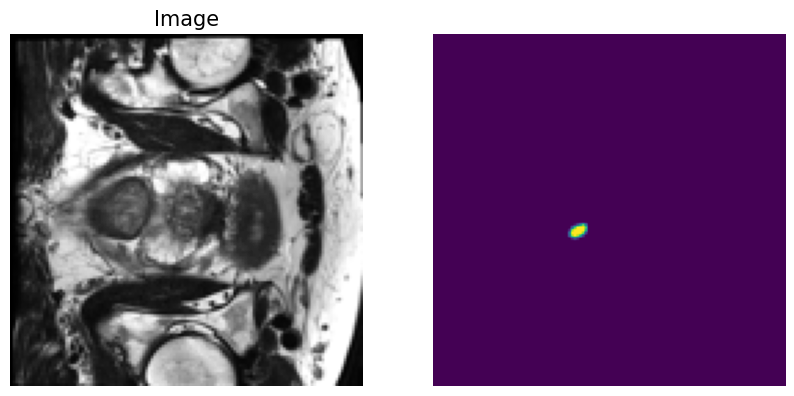

In [ ]:
# Explore the preprocessed image, label
interact(explore_3dimage2, layer=(0, 15))

## 3 attempt

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class MulticlassImageClassifier(nn.Module):
    def __init__(self):
        super(MulticlassImageClassifier, self).__init__()
        self.conv1 = nn.Conv3d(4, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 8 * 8 * 2, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.relu4 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 6)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(-1, 128 * 8 * 8 * 2)
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define the model, loss function and optimizer
model = MulticlassImageClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model(torch.randn(1,4,128,128,16)).shape

# # Train the model
# for epoch in range(num_epochs):
#     for i, (inputs, labels) in enumerate(train_loader):
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         if i % 100 == 0:
#             print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}")

# # Test the model
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for inputs, labels in test_loader:
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#     print(f"Test Accuracy: {(100 * correct / total):.2f}%")


torch.Size([4, 6])